In [446]:
import joblib
import pandas as pd
import pandas
import numpy as np
import sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import xgboost as xgb
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error
from flaml import AutoML

claims_data = pd.read_excel('claims_data.xlsx')

In [447]:
bins = [-1, 0, 50000]
labels = [0, 1]

# Binning the loss column into 2 categories
claims_data['Incurred_cat'] = pd.cut(claims_data['Incurred'], bins=bins, labels=labels)


#Some Basic Required Data cleaning so some sneaky errors 😉
claims_data = claims_data[~claims_data['Incurred_cat'].isna()]
claims_data["Incurred_cat"] = claims_data["Incurred_cat"].astype(int)
claims_data.loc[claims_data["Notification_period"] < 0, "Notification_period"] = np.nan
claims_data.loc[claims_data["PH_considered_TP_at_fault"] == "#", "PH_considered_TP_at_fault"] = np.nan
claims_data.drop(columns=["Claim Number", "date_of_loss", "Loss_code", "Loss_description", "Capped Incurred","Inception_to_loss"],
                 inplace=True)
claims_data = claims_data[~claims_data['Incurred_cat'].isna()] 

In [448]:
#Encoding Categorical Columns

def one_hot_encode_categorical_columns(df: pd.DataFrame) -> (pd.DataFrame, OneHotEncoder):
    """
    One-hot encodes all categorical columns in the DataFrame using OneHotEncoder.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame containing columns to be encoded.
    
    Returns:
    pd.DataFrame: The DataFrame with categorical columns one-hot encoded.
    """
    
    categorical_columns = df.select_dtypes(include=['object', 'category']).columns
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    encoded_df = pd.DataFrame(ohe.fit_transform(df[categorical_columns]))

    encoded_df.columns = ohe.get_feature_names_out(categorical_columns)
    df = df.drop(columns=categorical_columns).reset_index(drop=True)
    encoded_df = encoded_df.reset_index(drop=True)

    return pd.concat([df, encoded_df], axis=1), ohe


encoded_claims, encoder = one_hot_encode_categorical_columns(claims_data)
train, test = train_test_split(encoded_claims, test_size=0.20, random_state=32, shuffle=True)


In [449]:
dtypes_dict = claims_data.dtypes.astype(str).to_dict() 

#Removing values that one be used at inference time. But needed for training
dtypes_dict.pop("Incurred")
dtypes_dict.pop("Incurred_cat")

with open('dtypes_dict.json', 'w') as json_file:
    json.dump(dtypes_dict, json_file)

In [450]:
#Valid Json Response to test endpoint
with open('json_request.json', 'w') as json_file:
    json.dump(claims_data.loc[0].to_dict(), json_file)

In [451]:
from random import uniform, randint
from collections import namedtuple

DataSet = namedtuple('DataSet', ['features', 'target'])
train_set = DataSet(features=train.drop(columns=["Incurred_cat",'Incurred']), target=train["Incurred_cat"])
test_set = DataSet(features=test.drop(columns=["Incurred_cat",'Incurred']), target=test["Incurred_cat"])
train_d_matrix = xgb.DMatrix(train_set.features, label=train_set.target, enable_categorical=False)
test_d_matrix = xgb.DMatrix(test_set.features, label=test_set.target, enable_categorical=False)


# automl_classification = AutoML()
# 
# automl_clas_settings = {
#     "time_budget": 600,  # total running time in seconds
#     "metric": 'macro_f1',  # metric to optimize
#     "task": 'classification',  # task type
#     
#     "n_splits": 5,  # number of splits in time cross-validation
#     "sample": True,  # enable sampling
#     "estimator_list": ['xgboost'],  # list of ML algorithms to use
#     "log_file_name": 'flaml.log',  # log file
#     "eval_method": "cv",  # cross-validation
#     "max_iter": 200,  # maximum number of iterations
#     "early_stop": True,  # enable early stopping
#     "n_jobs": 4,  # number of parallel jobs
#     "ensemble": True,  # use ensemble methods
#     "custom_hp": {
#         'xgboost': {
#             'n_estimators': {'domain': randint(50, 500), 'init_value': 100},
#             'max_depth': {'domain': randint(3, 10), 'init_value': 6},
#             'subsample': {'domain': uniform(0.6, 1.0), 'init_value': 0.8},
#             'learning_rate': {'domain': uniform(0.1, 0.3), 'init_value': 0.1},
#         },
#     }
# }
# 
# automl_classification.fit(X_train=train_set.features, y_train=train_set.target, **automl_clas_settings)
# best_params = automl_classification.best_config

best_params = {'max_leaves': 27, 'min_child_weight': 5.934123526951441, 'colsample_bylevel': 0.9237064316343299,
               'colsample_bytree': 0.938515547014156, 'reg_alpha': 0.21802096600346335,
               'reg_lambda': 0.02190127779518735, 'n_estimators': 233, 'learning_rate': 0.15217498060598927,
               'subsample': 0.8633042594355675, 'max_depth': 9, "objective": "binary:logistic"}
best_clas_model = xgb.train(best_params, train_d_matrix, num_boost_round=110)

C:\Users\colin\PycharmProjects\claim_cost\claim_cost_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:37:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [452]:
joblib.dump(encoder, 'encoder.joblib')
best_clas_model.save_model("no_loss_proba_model.json")

Accuracy: 0.7342
Precision: 0.7803
Recall: 0.9023
F1 Score: 0.8369
ROC AUC Score: 0.7113
Confusion Matrix:
Classification Report:


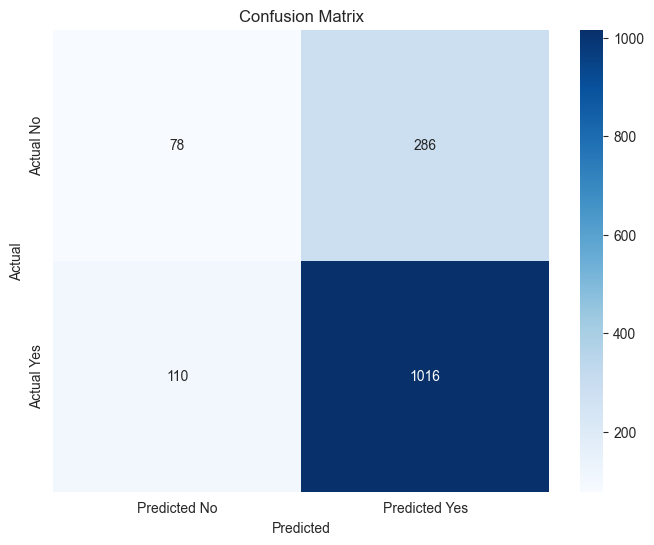

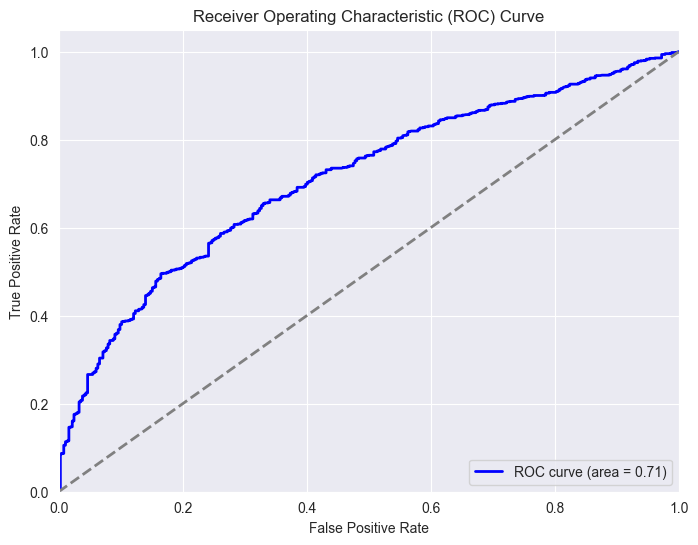

In [453]:
import numpy as np
import pandas as pd
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
import matplotlib.pyplot as plt
import seaborn as sns

test_predictions = (best_clas_model.predict(test_d_matrix) > 0.5).astype(int)
test_proba = best_clas_model.predict(test_d_matrix)

accuracy = accuracy_score(test_set.target, test_predictions)
print(f'Accuracy: {accuracy:.4f}')

precision = precision_score(test_set.target, test_predictions)
recall = recall_score(test_set.target, test_predictions)
f1 = f1_score(test_set.target, test_predictions)
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

roc_auc = roc_auc_score(test_set.target, test_proba)
print(f'ROC AUC Score: {roc_auc:.4f}')

conf_matrix = confusion_matrix(test_set.target, test_predictions)
print('Confusion Matrix:')

# Classification Report
class_report = classification_report(test_set.target, test_predictions)
print('Classification Report:')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Predicted No', 'Predicted Yes'], yticklabels=['Actual No', 'Actual Yes'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

fpr, tpr, _ = roc_curve(test_set.target, test_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

if hasattr(best_clas_model, 'feature_importances_'):
    feature_importance = best_clas_model.feature_importances_
    feature_names = test_set.features.columns
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': feature_importance})
    feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)
    
    plt.figure(figsize=(10, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance_df)
    plt.title('Feature Importance')
    plt.show()


                              Feature  Importance
0                 Notification_period       494.0
1                           Time_hour       478.0
12                       TP_injury_nk       136.0
38                   Vehicle_mobile_Y        93.0
31    Location_of_incident_Minor Road        90.0
11                  TP_injury_unclear        88.0
27                        Notifier_PH        82.0
5                      TP_type_driver        78.0
41                      Main_driver_Y        77.0
26                     Notifier_Other        77.0
34          Weather_conditions_NORMAL        75.0
43      PH_considered_TP_at_fault_n/k        72.0
30     Location_of_incident_Main Road        71.0
40                  Main_driver_Other        69.0
3              Injury_details_present        67.0
8                          TP_type_nk        67.0
2            Incident_details_present        60.0
9                  TP_injury_whiplash        46.0
36             Weather_conditions_WET        36.0


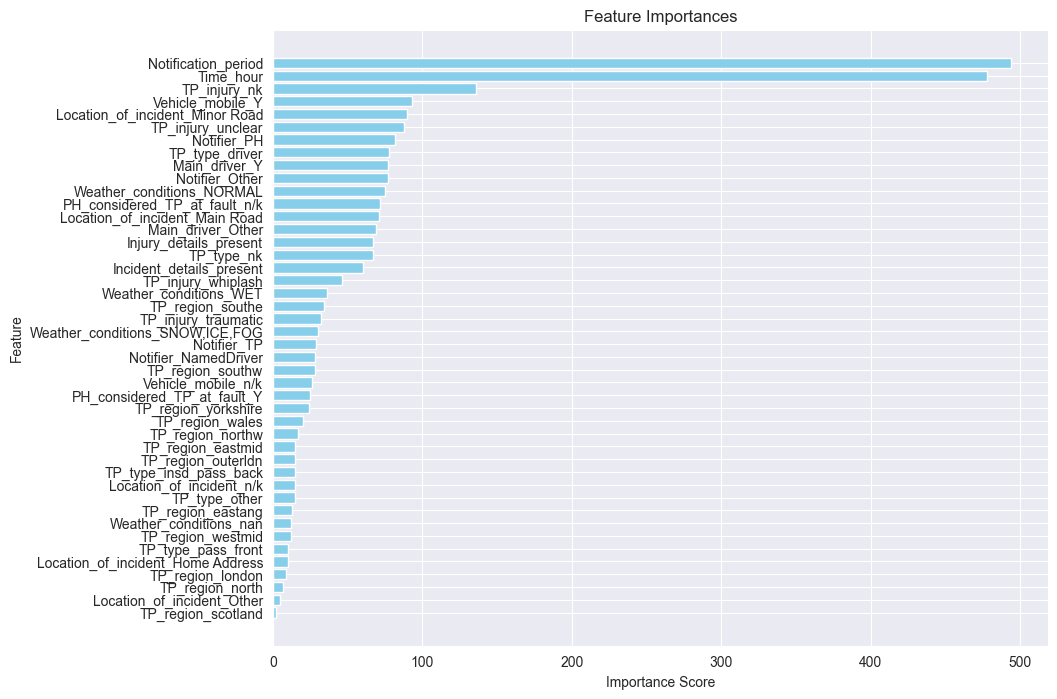

In [454]:
feature_importances = best_clas_model.get_score()

importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)

import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [455]:
train["loss_proba"] = best_clas_model.predict(train_d_matrix)
test["loss_proba"] = best_clas_model.predict(test_d_matrix)

In [469]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
from flaml import AutoML

DataSet = namedtuple('DataSet', ['features', 'target'])
train_set = DataSet(features=train.drop(columns=["Incurred_cat",'Incurred']), target=train["Incurred"])
test_set = DataSet(features=test.drop(columns=["Incurred_cat",'Incurred']), target=test["Incurred"])
train_d_matrix = xgb.DMatrix(train_set.features, label=train_set.target, enable_categorical=False)
test_d_matrix = xgb.DMatrix(test_set.features, label=test_set.target, enable_categorical=False)

# automl_regression = AutoML()
# 
# automl_reg_settings = {
#     "time_budget": 60,  # total running time in seconds
#     "metric": 'mse',  # metric to optimize
#     "task": 'regression',  # task type
#     "n_splits": 5,  # number of splits in time cross-validation
#     "sample": True,  # enable sampling
#     "estimator_list": ['xgboost'],  # list of ML algorithms to use
#     "log_file_name": 'flaml.log',  # log file
#     "eval_method": "cv",  # cross-validation
#     "max_iter": 200,  # maximum number of iterations
#     "early_stop": True,  # enable early stopping
#     "n_jobs": 4,  # number of parallel jobs
#     "ensemble": True,  # use ensemble methods
#     "custom_hp": {
#         'xgboost': {
#             'n_estimators': {'domain': randint(50, 500), 'init_value': 100},
#             'max_depth': {'domain': randint(3, 10), 'init_value': 6},
#             'subsample': {'domain': uniform(0.6, 1.0), 'init_value': 0.8},
#             'learning_rate': {'domain': uniform(0.1, 0.3), 'init_value': 0.1},
#         },
#     }
# }
# 
# automl_regression.fit(X_train=train_set.features, y_train=train_set.target, **automl_reg_settings)
# 
# print('Best hyperparameters:', automl_regression.best_config)
# 
# best_reg_params = automl_regression.best_config
best_reg_params = {'max_leaves': 4, 'min_child_weight': 0.9999999999999993, 'colsample_bylevel': 1.0, 'colsample_bytree': 1.0, 'reg_alpha': 0.0009765625, 'reg_lambda': 1.0, 'n_estimators': 488, 'learning_rate': 0.22816819063963767, 'subsample': 0.8534789330505146, 'max_depth': 8, 'objective': 'reg:squarederror'}
best_model = xgb.train(best_reg_params, train_d_matrix, num_boost_round=300)

test_predictions = best_model.predict(test_d_matrix)
mae = mean_absolute_error(test_set.target, test_predictions)
print(f'Test MAE: {mae}')

mse = mean_squared_error(test_set.target, test_predictions)
print(f'Test MSE: {mse}')

Test MAE: 3864.174427509808
Test MSE: 41654672.70474357


C:\Users\colin\PycharmProjects\claim_cost\claim_cost_env\Lib\site-packages\xgboost\core.py:160: UserWarning: [20:37:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


                                Feature  Importance
47                           loss_proba       139.0
1                             Time_hour        55.0
0                   Notification_period        50.0
28                  TP_region_yorkshire        44.0
10                        TP_type_other        42.0
6                        TP_type_driver        40.0
16                         TP_injury_nk        39.0
12                   TP_injury_whiplash        38.0
21                     TP_region_northw        35.0
13                  TP_injury_traumatic        31.0
15                    TP_injury_unclear        30.0
7                     TP_type_pass_back        29.0
18                    TP_region_eastmid        29.0
24                     TP_region_southe        28.0
19                     TP_region_london        23.0
26                      TP_region_wales        16.0
46        PH_considered_TP_at_fault_n/k        15.0
8                    TP_type_pass_front        15.0
5           

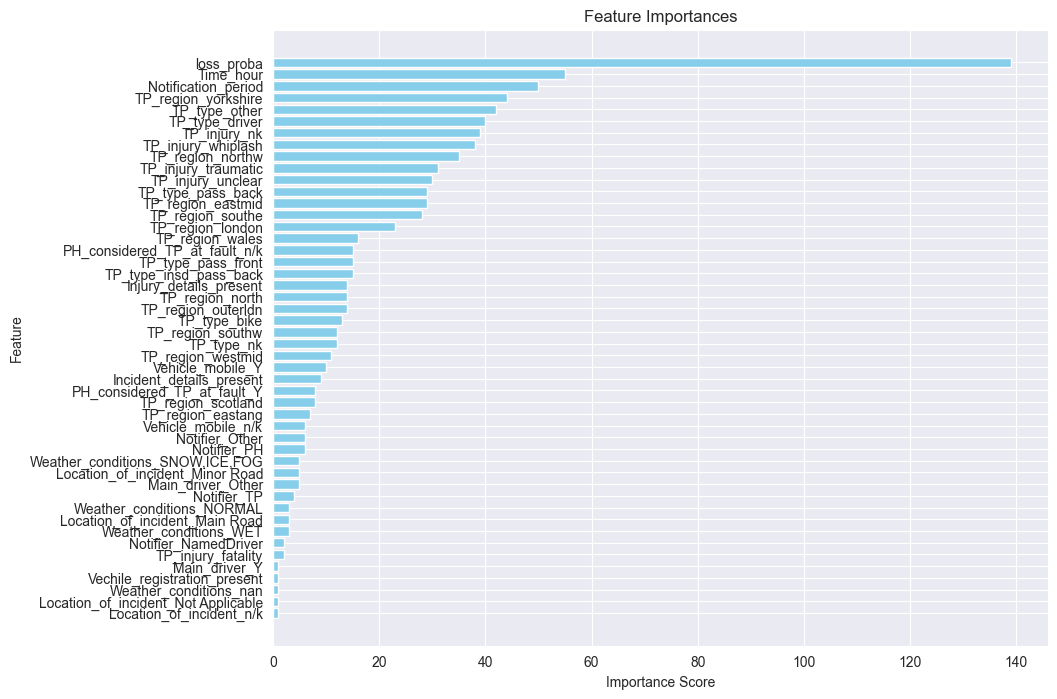

In [457]:
feature_importances = best_model.get_score()

importance_df = pd.DataFrame(list(feature_importances.items()), columns=['Feature', 'Importance'])

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display the DataFrame
print(importance_df)

import matplotlib.pyplot as plt

# Plot the feature importances
plt.figure(figsize=(10, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importances')
plt.gca().invert_yaxis()  # Highest importance at the top
plt.show()

In [458]:
best_model.save_model("claims_model.json")

In [459]:
actual_df = pd.DataFrame(data=test_set.target, columns=["Incurred"]).reset_index(drop=True)
predicted_df = pd.DataFrame(data=test_predictions.tolist(), columns=["Predicted"]).reset_index(drop=True)
result_df = pd.concat([actual_df, predicted_df], axis=1)
result_df["LazyPredict"] = train_set.target.mean()

In [460]:
#group incurred values into bins of 0 to 100k goign up 1k increments
bins = [value for value in range(-1, 100001, 5000)]
labels = [f"{value}-{value+999}" for value in range(0, 100000, 5000)]
result_df["Incurred_bin"] = pd.cut(result_df["Incurred"], bins=bins, labels=labels)

In [461]:
f"MAE with Model: {mean_absolute_error(result_df['Incurred'], result_df['Predicted'])}, MAE with LazyPredict: {mean_absolute_error(result_df['Incurred'], result_df['LazyPredict'])}"

'MAE with Model: 3864.174427509808, MAE with LazyPredict: 5738.354288381166'

In [462]:
Incurred_Costs = result_df["Incurred"].sum() 
Incurred_Costs

6798604.3199088

In [463]:
Model_Predicted_Costs = result_df["Predicted"].sum()
Model_Predicted_Costs

7380793.9059352875

In [464]:
LazyPredict_Costs = result_df["LazyPredict"].sum()
LazyPredict_Costs

7581346.149964498

In [465]:
Model_Predicted_Costs-LazyPredict_Costs

#Implimenting this would save aroudn 200k cash flow per year, at 3% interest rate, this saves 6k per year. Or at 10% ROI can generate 10k per year. Assuming the current method is not better than the lazy forcasting. 

-200552.24402921088

In [466]:
#group by the bins and get the mean of the incurred and predicted values. Save the Sum of the incurred values, predicted values and LazyPredict values and the difference between the incurred and predicted values
aggregated_df = result_df.groupby("Incurred_bin").agg({"Incurred": "sum", "Predicted": "sum", "LazyPredict": "sum"}).reset_index()
aggregated_df["Incurred_Predicted_Difference"] = (aggregated_df["Incurred"] - aggregated_df["Predicted"])
aggregated_df["Incurred_LazyPredict_Difference"] = aggregated_df["Incurred"] - aggregated_df["LazyPredict"]

#convert all non bin columns to int
aggregated_df["Incurred"] = aggregated_df["Incurred"].astype(int)
aggregated_df["Predicted"] = aggregated_df["Predicted"].astype(int)
aggregated_df["LazyPredict"] = aggregated_df["LazyPredict"].astype(int)
aggregated_df["Incurred_Predicted_Difference"] = aggregated_df["Incurred_Predicted_Difference"].astype(int)
aggregated_df["Incurred_LazyPredict_Difference"] = aggregated_df["Incurred_LazyPredict_Difference"].astype(int)

C:\Users\colin\AppData\Local\Temp\ipykernel_164604\620116029.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = result_df.groupby("Incurred_bin").agg({"Incurred": "sum", "Predicted": "sum", "LazyPredict": "sum"}).reset_index()


In [467]:
aggregated_df

,Incurred_bin,Incurred,Predicted,LazyPredict,Incurred_Predicted_Difference,Incurred_LazyPredict_Difference
0,0-999,1088618,3370959,5754699,-2282341,-4666081
1,5000-5999,965935,1029018,681812,-63083,284123
2,10000-10999,909994,766969,386699,143025,523294
3,15000-15999,820330,565960,239143,254369,581187
4,20000-20999,860219,558971,193349,301247,666869
5,25000-25999,743356,464327,137380,279028,605976
6,30000-30999,512057,285444,81410,226612,430646
7,35000-35999,262052,102338,35617,159714,226435
8,40000-40999,206627,80365,25440,126261,181186
9,45000-45999,429413,156437,45793,272975,383619


C:\Users\colin\AppData\Local\Temp\ipykernel_164604\714932299.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  aggregated_df = result_df.groupby("Incurred_bin").agg({"Incurred": "mean", "Predicted": "mean", "LazyPredict": "mean"}).reset_index()


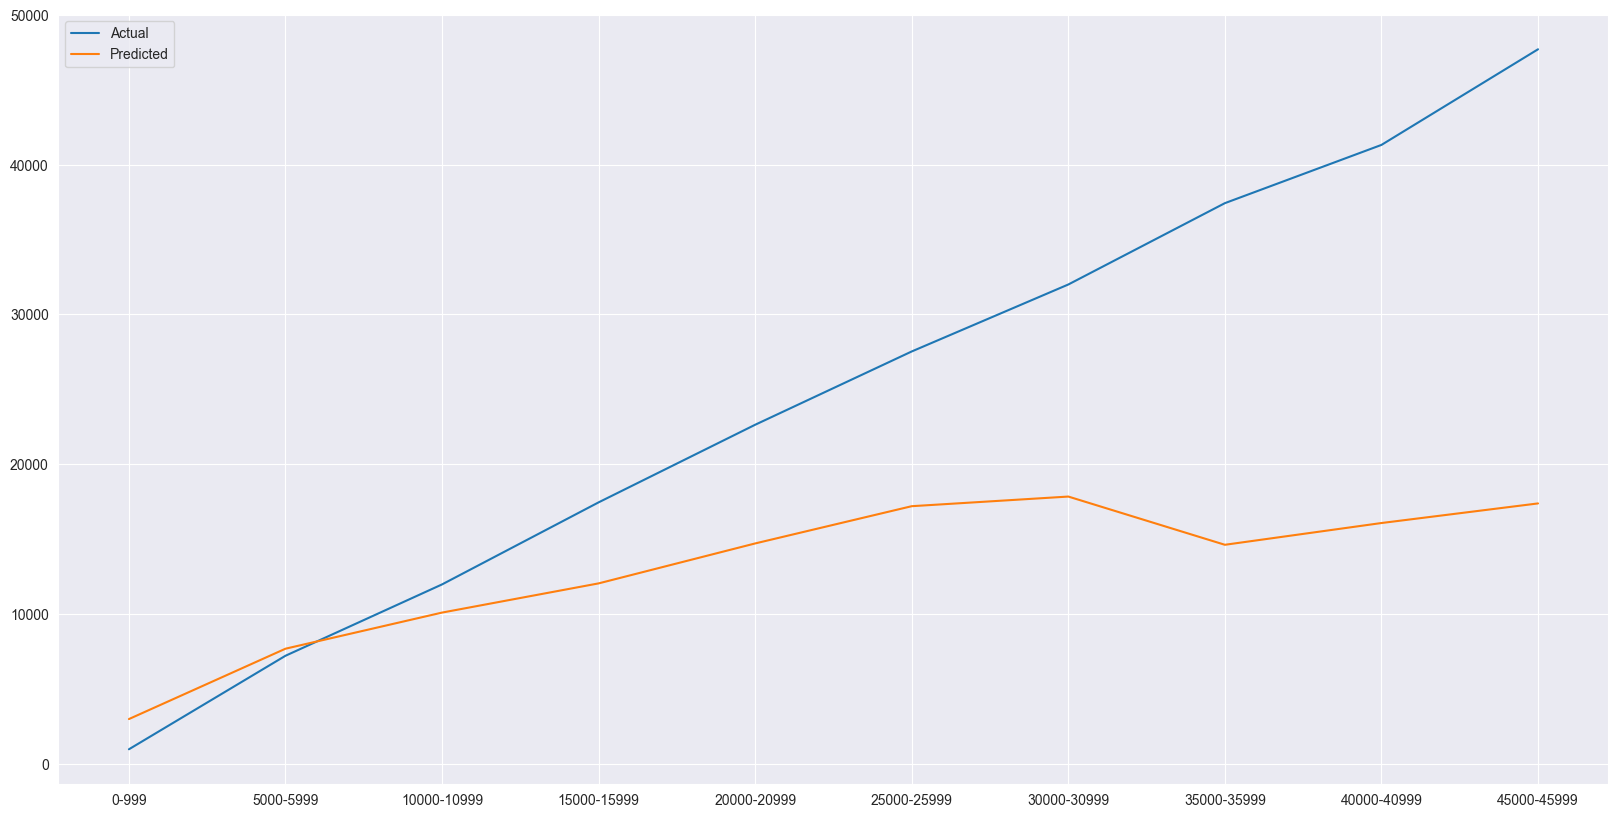

In [468]:
#group by the bins and get the mean of the incurred and predicted values. Save the Sum of the incurred values, predicted values and LazyPredict values and the difference between the incurred and predicted values
aggregated_df = result_df.groupby("Incurred_bin").agg({"Incurred": "mean", "Predicted": "mean", "LazyPredict": "mean"}).reset_index()

#plot the results
plt.figure(figsize=(20, 10))
plt.plot(aggregated_df["Incurred_bin"], aggregated_df["Incurred"], label="Actual")
plt.plot(aggregated_df["Incurred_bin"], aggregated_df["Predicted"], label="Predicted")
plt.legend()
plt.show()


In [468]:
 # How to improve the model going forward

#change the no loss model to predict the band of which it thinks the loss will be in. This will help the model to predict the loss more accurately
# Could do some cluster analysis to see if there are any patterns in the data that could be used to improve the model
# Outlier modelling to try and catchh the values are are 5-10+ 
# Try some quantile regression with xgboost to see if a more conservative model would be better at picking up the higher values

# How long its been since the crash isnt used as feature since these are all historic cases, if this was known this could be a feature. I noted that this was a high feature in the feature importance and likely is a good feature to use. 
# We could also do with having a breakdown fo the costs assosiated with a claim, that way the model might targets that are more linearly corrolated. 

# how would I feed this back to non technical people. Show them the aggregated results, the plotted results. Have a training session on how to use the model and how to interpret the results. However at this stage is not suitable to predict single models rather a population. 

